# Devoir 1

## 1 - Fonctions utiles

In [35]:
import numpy as np
import pandas as pd
import sklearn


# Fonction pour le calcul de la matrice de confusion
def compute_confusion_matrix(y_true, y_pred, classes, abreviations=None):
    """Compute the confusion matrix and performance metrics

    This function computes the confusion matrix and performance measures such as
    recall, precision and accuracy. The confusion matrix and the performance metrics
    are written in a pandas DataFrame.

    Parameters
    ----------
    y_true : numpy.ndarray
        Array containing the true numeric classes from the data.
    y_pred : numpy.ndarray
        Array containing the predicted numeric classes by the model.
    classes : list, numpy.ndarray
        List of labels for the classes of the data.capitalize
    abreviations : list, numpy.ndarray, default: None
        List of abreviations for the classes to use as table columns. If None, use the
        classes also for the columns.

    Returns
    -------
    pandas.DataFrame
        Dataframe containing the confusion matrix and performance metrics.

    """
    if abreviations is None:
        abreviations = classes

    # Compute confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

    # Diagonal range index
    idx = np.arange(confusion_matrix.shape[0])

    # Recall
    recall = confusion_matrix[idx, idx] / confusion_matrix.sum(axis=1)

    # Precision
    precision = confusion_matrix[idx, idx] / confusion_matrix.sum(axis=0)

    # Accuracy
    accuracy = confusion_matrix[idx, idx].sum() / confusion_matrix.sum()

    # Creating dataframe
    columns = list(abreviations) + ["Recall"]
    rows = list(classes) + ["Precision"]
    df = pd.DataFrame(np.nan, index=rows, columns=columns)
    df.loc[classes, abreviations] = confusion_matrix
    df.loc[classes, "Recall"] = recall
    df.loc["Precision", abreviations] = precision
    df.loc["Precision", "Recall"] = accuracy

    return df

In [2]:
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory

plt.rcParams["axes.autolimit_mode"] = "round_numbers"


# Fonction pour l'affichage de la matrice de confusion
def display_confusion_matrix(ax, confusion_matrix, origin="upper", title=None):
    """Display the confusion matrix in a matplotlib figure

    This function uses matplotlib to display the confusion matrix with the
    :func:`matplotlib.pyplot.imshow` function.

    Parameters
    ----------
    confusion_matrix : pandas.DataFrame
        Dataframe containing the confusion matrix and the performance metrics such as
        recall, precision and accuracy. The `confusion_matrix` is generally returned
        from the `compute_confusion_matrix` function of this notebook.

    origin : {'upper', 'lower'}, default: 'upper'
        Whether to display the confusion matrix using a upper left origin or a lower
        left origin.

    Returns
    -------
    matplotlib.figure.Figure
        The matplotlib figure object that is created using this function

    """
    classes = confusion_matrix.columns[:-1]

    if origin == "upper":
        ax.xaxis.tick_top()
        ax.xaxis.set_label_position("top")

    img = ax.imshow(
        confusion_matrix.values[:-1, :-1], cmap="Blues", origin=origin, vmin=0
    )

    ax.set_yticks(np.arange(len(classes)), labels=classes)
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)

    # Adding labels
    ax.set_ylabel("True class", size=16)
    ax.set_xlabel("Predicted class", size=16)

    # Adding test
    for i in range(len(classes)):
        for j in range(len(classes)):
            value = confusion_matrix.values[i, j]
            vmax = img.get_clim()[1]
            color = "w" if value > 0.5 * vmax else "k"
            ax.text(
                j,
                i,
                f"{value:0.0f}",
                ha="center",
                va="center",
                color=color,
            )

    # Adding precision and recall
    x_trans = blended_transform_factory(ax.transData, ax.transAxes)
    y_trans = blended_transform_factory(ax.transAxes, ax.transData)

    # Precision
    ax.text(
        -0.01,
        -0.07,
        "PRECISION",
        ha="right",
        va="center",
        color="k",
        fontweight="bold",
        transform=ax.transAxes,
    )

    # Recall
    ax.text(
        1.1,
        1.01,
        "RECALL",
        ha="center",
        va="bottom" if origin == "upper" else "top",
        color="k",
        rotation=90,
        fontweight="bold",
        transform=ax.transAxes,
    )

    # Accuracy
    ax.text(
        1.1,
        -0.07,
        f"{100*confusion_matrix.iloc[-1,-1]:0.0f}%",
        ha="center",
        va="center",
        color="k",
        fontweight="bold",
        transform=ax.transAxes,
    )

    for i in range(len(classes)):
        ax.text(
            i,
            -0.07,
            f"{100*confusion_matrix.iloc[-1, i]:0.0f}%",
            ha="center",
            va="center",
            color="k",
            transform=x_trans,
        )

        ax.text(
            1.1,
            i,
            f"{100*confusion_matrix.iloc[i, -1]:0.0f}%",
            ha="center",
            va="center",
            color="k",
            transform=y_trans,
        )

    # Set title
    if title is not None:
        ax.set_title(title, fontsize=18, fontweight="bold")

## 2 - Perceptron multi-classes

In [ ]:
import numpy as np


class Perceptron(object):
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    target_class : int, default 0
        In a One versus All setup, the class that will be considered
        against all others.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications (updates) in each epoch.

    """

    def __init__(self, eta=0.01, n_iter=10, target_class=0):
        self.eta = eta
        self.n_iter = n_iter
        self.target_class = target_class

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.errors_ = []

        # One VS all
        one_vs_all_y = np.where(y == self.target_class, 1, -1)

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, one_vs_all_y):
                update = self.eta * (target - self.predict(xi))
                self.w_[1:] += update * xi

                self.w_[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [4]:
class MultiClassPerceptron(object):
    def __init__(self, eta=0.01, n_iter=10, prng=None):
        self.eta = eta
        self.n_iter = n_iter
        self.perceptrons = []

        if isinstance(prng, np.random.Generator):
            self.prng = prng
        else:
            self.prng = np.random.default_rng(prng)

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        # Reset perceptrons
        self.perceptrons = []

        # Get unique y values
        unique_y = np.unique(y)

        # Fit a perceptron for each unique value
        for uy in unique_y:
            pct = Perceptron(self.eta, self.n_iter, target_class=uy)
            pct.fit(X, y)
            self.perceptrons.append(pct)

        return self

    def predict(self, X):
        """Return class label after unit step"""

        # Single test value
        if len(X.shape) == 1:
            X = X.reshape(1, len(X))

        # Accumulate results
        results = np.zeros((len(X), len(self.perceptrons)), dtype=int)

        # Compute prediction for each perceptron
        for i, pct in enumerate(self.perceptrons):
            results[:, i] = np.where(pct.predict(X) == 1, pct.target_class, -1)

        # Iterate over rows:
        possible_labels = np.array([p.target_class for p in self.perceptrons])
        labels = np.zeros(len(results), dtype=int)

        for i, row in enumerate(results):
            # Get a random value between all active perceptrons
            activated = row[np.where(row != -1)[0]]

            # If none are activated, return any label
            if len(activated) == 0:
                lbl = self.prng.choice(possible_labels)
            # If only one is activated, return this label
            elif len(activated) == 1:
                lbl = activated[0]
            # If more than one is activated, return a random label between activated
            else:
                lbl = self.prng.choice(activated)

            labels[i] = lbl

        # Return the target class
        return labels

In [5]:
import pandas as pd
from sklearn.utils import shuffle

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
    header=None,
)
df[4] = df[4].astype("category")
df = shuffle(df, random_state=42)
df

,0,1,2,3,4
73,6.1,2.8,4.7,1.2,Iris-versicolor
18,5.7,3.8,1.7,0.3,Iris-setosa
118,7.7,2.6,6.9,2.3,Iris-virginica
78,6.0,2.9,4.5,1.5,Iris-versicolor
76,6.8,2.8,4.8,1.4,Iris-versicolor
...,...,...,...,...,...
71,6.1,2.8,4.0,1.3,Iris-versicolor
106,4.9,2.5,4.5,1.7,Iris-virginica
14,5.8,4.0,1.2,0.2,Iris-setosa
92,5.8,2.6,4.0,1.2,Iris-versicolor


In [6]:
y_train = df.iloc[0:100, 4].cat.codes.to_numpy(int)
X_train = df.iloc[0:100, :4].values

y_test = df.iloc[100:150, 4].cat.codes.to_numpy(int)
X_test = df.iloc[100:150, :4].values

y_train

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2])

In [7]:
ppn = MultiClassPerceptron(eta=0.01, n_iter=100, prng=7654321098)
ppn.fit(X_train, y_train)

In [8]:
res = pd.DataFrame(
    {"y_train": y_train}
    | {f"y_{p.target_class}": p.predict(X_train) for p in ppn.perceptrons}
    | {"y_pred": ppn.predict(X_train)}
)
res

,y_train,y_0,y_1,y_2,y_pred
0,1,-1,-1,-1,0
1,0,1,-1,-1,0
2,2,-1,-1,1,2
3,1,-1,-1,-1,2
4,1,-1,-1,-1,2
...,...,...,...,...,...
95,1,-1,-1,-1,0
96,0,1,-1,-1,0
97,0,1,-1,-1,0
98,2,-1,-1,1,2


(0.0, 60.0)

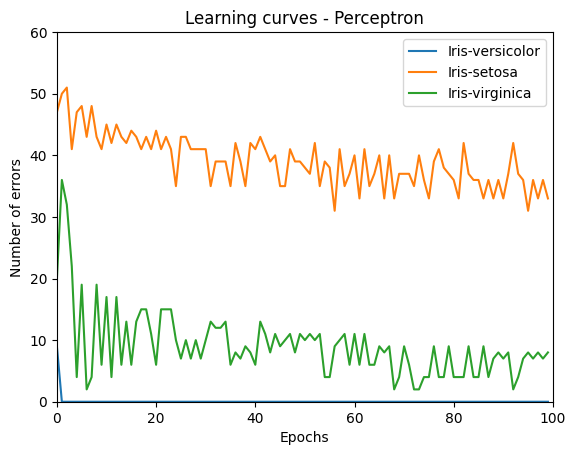

In [9]:
fig, ax = plt.subplots()
classes = {code: cat for code, cat in zip(df[4].cat.codes, df[4].cat.categories)}

for p in ppn.perceptrons:
    ax.plot(p.errors_, label=classes[p.target_class])

ax.set_ylabel("Number of errors")
ax.set_xlabel("Epochs")
ax.legend(loc="upper right")
ax.set_title("Learning curves - Perceptron")
ax.set_xlim(0, ppn.n_iter)
ax.set_ylim(0, None)

,Iris-versicolor,Iris-setosa,Iris-virginica,Recall
Iris-versicolor,13.0000,0.0,0.000000,1.000000
Iris-setosa,3.0000,8.0,7.000000,0.444444
Iris-virginica,0.0000,0.0,19.000000,1.000000
Precision,0.8125,1.0,0.730769,0.800000


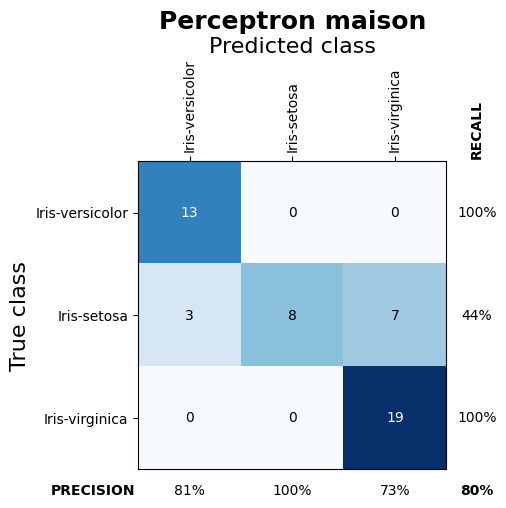

In [10]:
y_pred = ppn.predict(X_test)
classes = {code: cat for code, cat in zip(df[4].cat.codes, df[4].cat.categories)}
class_labels = [classes[i] for i in range(3)]

confusion_matrix = compute_confusion_matrix(y_test, y_pred, class_labels)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
display_confusion_matrix(ax, confusion_matrix, title="Perceptron maison")
confusion_matrix

In [11]:
# Scikit learn
import sklearn

ppn2 = sklearn.linear_model.Perceptron(eta0=0.01, max_iter=100)

In [12]:
ppn2.fit(X_train, y_train)

Perceptron(eta0=0.01, max_iter=100)

/tmp/ipykernel_4237/2214239867.py:43: RuntimeWarning: invalid value encountered in divide
  precision = confusion_matrix[idx, idx] / confusion_matrix.sum(axis=0)


,Iris-versicolor,Iris-setosa,Iris-virginica,Recall
Iris-versicolor,13.000000,0.0,0.000000,1.00
Iris-setosa,15.000000,0.0,3.000000,0.00
Iris-virginica,0.000000,0.0,19.000000,1.00
Precision,0.464286,NaN,0.863636,0.64


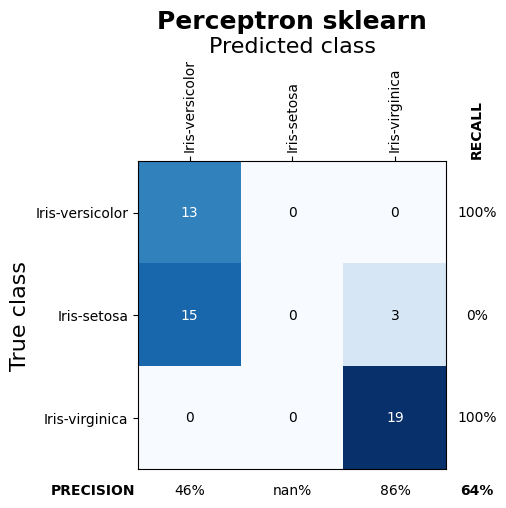

In [13]:
y_pred = ppn2.predict(X_test)
classes = {code: cat for code, cat in zip(df[4].cat.codes, df[4].cat.categories)}
class_labels = [classes[i] for i in range(3)]

confusion_matrix = compute_confusion_matrix(y_test, y_pred, class_labels)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
display_confusion_matrix(ax, confusion_matrix, title="Perceptron sklearn")
confusion_matrix

## 3 - Adaline multi-classes

In [14]:
import numpy as np


class AdalineGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    cost_ : list
        Sum-of-squares cost function value in each epoch.

    """

    def __init__(self, eta=0.01, n_iter=50, target_class=0):
        self.eta = eta
        self.n_iter = n_iter
        self.target_class = target_class

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = np.zeros(self.n_iter)

        # One VS all
        one_vs_all_y = np.where(y == self.target_class, 1, -1)

        for i in range(self.n_iter):
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,
            # in the case of logistic regression, we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(X)
            errors = one_vs_all_y - output
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_[i] = cost
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

In [15]:
class MultiClassAdaline(object):
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter
        self.adalines = []

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like, shape = [n_samples]
            Target values.

        Returns
        -------
        self : object

        """
        # Reset adalines
        self.adalines = []

        # Get unique y values
        unique_y = np.unique(y)

        # Fit a perceptron for each unique value
        for uy in unique_y:
            adl = AdalineGD(self.eta, self.n_iter, target_class=uy)
            adl.fit(X, y)
            self.adalines.append(adl)

        return self

    def predict(self, X):
        """Return class label after unit step"""

        # Single test value
        if len(X.shape) == 1:
            X = X.reshape(1, len(X))

        # Accumulate results
        results = np.zeros((len(X), len(self.adalines)))

        # Compute prediction for each adaline
        for i, adl in enumerate(self.adalines):
            results[:, i] = adl.activation(X)

        # Iterate over rows:
        possible_labels = np.array([a.target_class for a in self.adalines])
        labels = possible_labels[np.argmax(results, axis=1)]

        # Return the target class
        return labels

In [16]:
import pandas as pd
from sklearn.utils import shuffle

df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",
    header=None,
)
df[4] = df[4].astype("category")
df = shuffle(df, random_state=42)
df

,0,1,2,3,4
73,6.1,2.8,4.7,1.2,Iris-versicolor
18,5.7,3.8,1.7,0.3,Iris-setosa
118,7.7,2.6,6.9,2.3,Iris-virginica
78,6.0,2.9,4.5,1.5,Iris-versicolor
76,6.8,2.8,4.8,1.4,Iris-versicolor
...,...,...,...,...,...
71,6.1,2.8,4.0,1.3,Iris-versicolor
106,4.9,2.5,4.5,1.7,Iris-virginica
14,5.8,4.0,1.2,0.2,Iris-setosa
92,5.8,2.6,4.0,1.2,Iris-versicolor


In [17]:
y_train = df.iloc[0:100, 4].cat.codes.to_numpy(int)
X_train = df.iloc[0:100, :4].values

y_test = df.iloc[100:150, 4].cat.codes.to_numpy(int)
X_test = df.iloc[100:150, :4].values

y_train

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2,
       0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
       1, 2, 0, 1, 2, 0, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 0, 1, 1, 0, 2, 0,
       0, 1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 2])

In [18]:
adl = MultiClassAdaline(eta=0.0001, n_iter=500)
adl.fit(X_train, y_train)

In [19]:
res = pd.DataFrame(
    {"y_train": y_train}
    | {f"y_{a.target_class}": a.activation(X_train) for a in adl.adalines}
    | {"y_pred": adl.predict(X_train)}
)
res

,y_train,y_0,y_1,y_2,y_pred
0,1,-0.780881,-0.127505,-0.074385,2
1,0,0.952507,-0.796674,-1.269974,0
2,2,-1.845691,0.149485,0.603714,2
3,1,-0.725823,-0.236477,-0.011332,2
4,1,-0.798013,-0.131891,-0.136189,1
...,...,...,...,...,...
95,1,-0.646947,-0.170356,-0.071335,2
96,0,0.697488,-0.567919,-1.000837,0
97,0,0.867332,-0.634123,-1.110064,0
98,2,-1.163812,0.061763,0.202952,2


(0.0, 60.0)

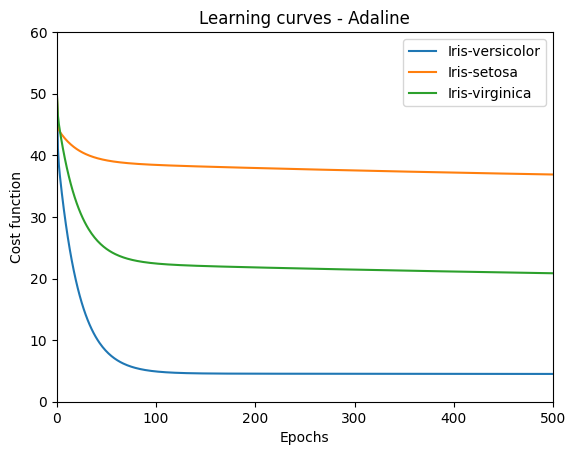

In [20]:
fig, ax = plt.subplots()
classes = {code: cat for code, cat in zip(df[4].cat.codes, df[4].cat.categories)}

for a in adl.adalines:
    ax.plot(a.cost_, label=classes[a.target_class])

ax.set_ylabel("Cost function")
ax.set_xlabel("Epochs")
ax.legend(loc="upper right")
ax.set_title("Learning curves - Adaline")
ax.set_xlim(0, adl.n_iter)
ax.set_ylim(0, None)

,Iris-versicolor,Iris-setosa,Iris-virginica,Recall
Iris-versicolor,13.0,0.0,0.00000,1.000000
Iris-setosa,0.0,5.0,13.00000,0.277778
Iris-virginica,0.0,0.0,19.00000,1.000000
Precision,1.0,1.0,0.59375,0.740000


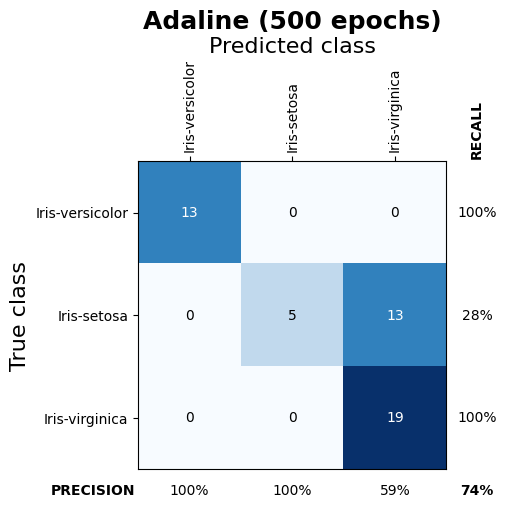

In [21]:
y_pred = adl.predict(X_test)
classes = {code: cat for code, cat in zip(df[4].cat.codes, df[4].cat.categories)}
class_labels = [classes[i] for i in range(3)]

confusion_matrix = compute_confusion_matrix(y_test, y_pred, class_labels)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
display_confusion_matrix(ax, confusion_matrix, title="Adaline (500 epochs)")
confusion_matrix

In [22]:
adl2 = MultiClassAdaline(eta=0.0001, n_iter=5000)
adl2.fit(X_train, y_train)

(0.0, 60.0)

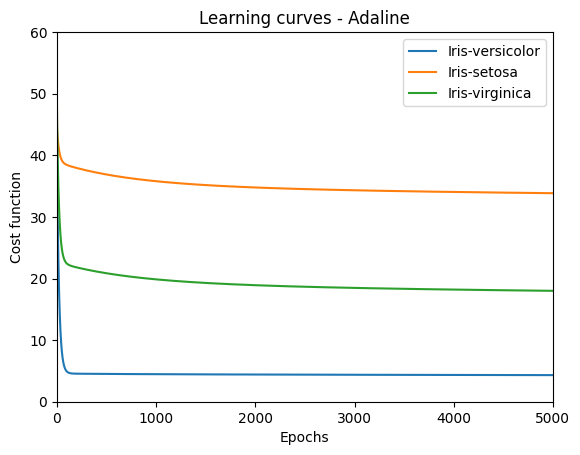

In [23]:
fig, ax = plt.subplots()
classes = {code: cat for code, cat in zip(df[4].cat.codes, df[4].cat.categories)}

for a in adl2.adalines:
    ax.plot(a.cost_, label=classes[a.target_class])

ax.set_ylabel("Cost function")
ax.set_xlabel("Epochs")
ax.legend(loc="upper right")
ax.set_title("Learning curves - Adaline")
ax.set_xlim(0, adl2.n_iter)
ax.set_ylim(0, None)

,Iris-versicolor,Iris-setosa,Iris-virginica,Recall
Iris-versicolor,13.0,0.000000,0.0,1.000000
Iris-setosa,0.0,14.000000,4.0,0.777778
Iris-virginica,0.0,3.000000,16.0,0.842105
Precision,1.0,0.823529,0.8,0.860000


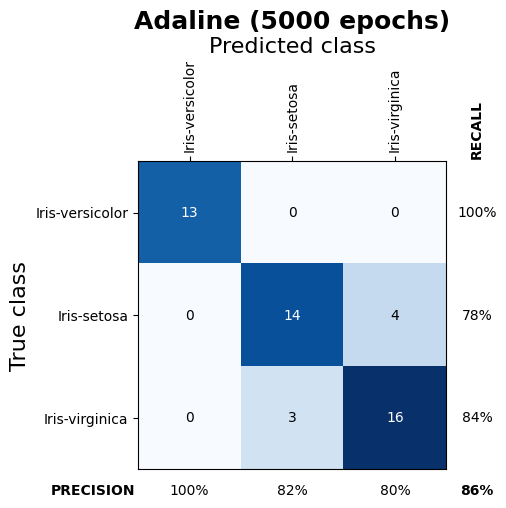

In [24]:
y_pred = adl2.predict(X_test)
classes = {code: cat for code, cat in zip(df[4].cat.codes, df[4].cat.categories)}
class_labels = [classes[i] for i in range(3)]

confusion_matrix = compute_confusion_matrix(y_test, y_pred, class_labels)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
display_confusion_matrix(ax, confusion_matrix, title="Adaline (5000 epochs)")
confusion_matrix

## 4 - Test de classement des champignons

In [25]:
import pandas as pd
from sklearn.utils import shuffle

df = pd.read_csv("glass.data", header=None, index_col=0)
df = shuffle(df, random_state=42)
df

,1,2,3,4,5,6,7,8,9,10
0,,,,,,,,,,
10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.00,0.11,1
198,1.51727,14.70,0.00,2.34,73.28,0.00,8.95,0.66,0.00,7
67,1.52152,13.05,3.65,0.87,72.22,0.19,9.85,0.00,0.17,1
192,1.51602,14.85,0.00,2.38,73.28,0.00,8.76,0.64,0.09,7
118,1.51708,13.72,3.68,1.81,72.06,0.64,7.88,0.00,0.00,2
...,...,...,...,...,...,...,...,...,...,...
107,1.53125,10.73,0.00,2.10,69.81,0.58,13.30,3.15,0.28,2
15,1.51763,12.61,3.59,1.31,73.29,0.58,8.50,0.00,0.00,1
93,1.51588,13.12,3.41,1.58,73.26,0.07,8.39,0.00,0.19,2


In [26]:
X_train = df.iloc[0:140, 0:-1].to_numpy(float)
y_train = df.iloc[0:140, -1].to_numpy(int)

X_test = df.iloc[140:, 0:-1].to_numpy(float)
y_test = df.iloc[140:, -1].to_numpy(int)

y_train

array([1, 7, 1, 7, 2, 2, 1, 2, 2, 2, 6, 5, 2, 2, 6, 5, 7, 1, 1, 6, 2, 7,
       7, 7, 3, 2, 1, 1, 5, 1, 1, 2, 3, 2, 1, 7, 5, 3, 2, 2, 2, 7, 1, 2,
       3, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 7, 2, 5, 1, 1, 2, 1, 7, 5, 2,
       1, 2, 6, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 5, 2, 1, 3, 2, 2, 1, 2, 2,
       2, 1, 2, 1, 3, 2, 2, 2, 2, 1, 7, 1, 1, 2, 2, 1, 1, 7, 6, 1, 1, 2,
       7, 3, 1, 1, 2, 3, 2, 3, 2, 1, 1, 2, 3, 6, 1, 7, 3, 2, 5, 1, 1, 2,
       1, 2, 1, 7, 3, 2, 1, 7])

In [27]:
# Normalisation
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
print(mean)
print(std)

X_train = (X_train - mean[None, :]) / std[None, :]
X_test = (X_test - mean[None, :]) / std[None, :]

[1.51790800e+00 1.34038571e+01 2.79942857e+00 1.44857143e+00
 7.27219286e+01 5.17642857e-01 8.80435714e+00 1.24000000e-01
 5.80000000e-02]
[0.00250908 0.75360143 1.3800651  0.47903112 0.64129433 0.74389862
 1.22743357 0.35369236 0.0955899 ]


In [28]:
adl = MultiClassAdaline(eta=0.0001, n_iter=500)
adl.fit(X_train, y_train)

(0.0, 80.0)

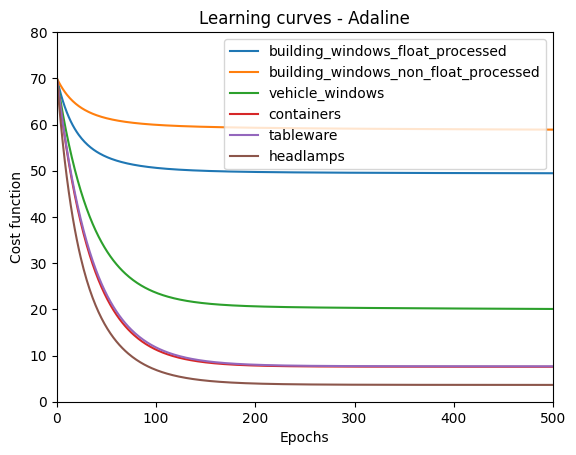

In [29]:
fig, ax = plt.subplots()
classes = {
    1: "building_windows_float_processed",
    2: "building_windows_non_float_processed",
    3: "vehicle_windows",
    5: "containers",
    6: "tableware",
    7: "headlamps",
}

for a in adl.adalines:
    ax.plot(a.cost_, label=classes[a.target_class])

ax.set_ylabel("Cost function")
ax.set_xlabel("Epochs")
ax.legend(loc="upper right")
ax.set_title("Learning curves - Adaline")
ax.set_xlim(0, adl.n_iter)
ax.set_ylim(0, None)

/tmp/ipykernel_4237/2214239867.py:43: RuntimeWarning: invalid value encountered in divide
  precision = confusion_matrix[idx, idx] / confusion_matrix.sum(axis=0)


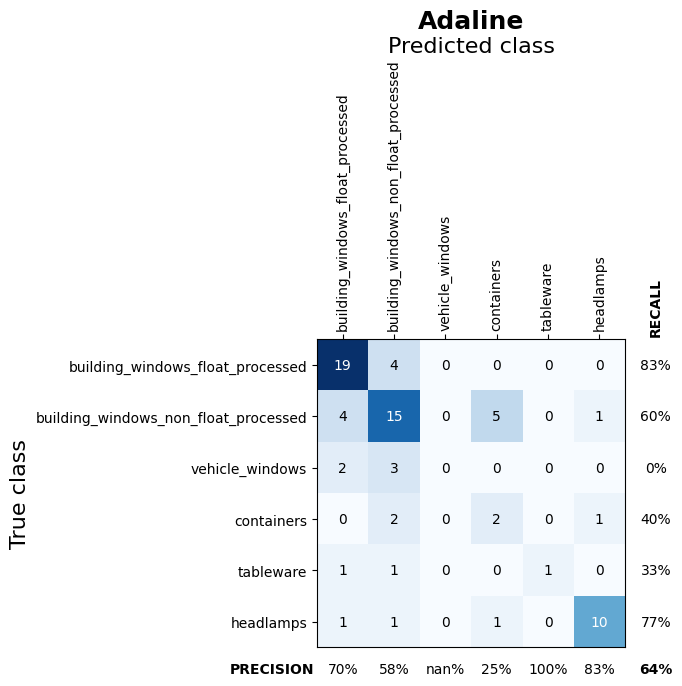

In [30]:
y_pred = adl.predict(X_test)

confusion_matrix = compute_confusion_matrix(y_test, y_pred, classes.values())

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
display_confusion_matrix(ax, confusion_matrix, title="Adaline")

In [31]:
ppn = MultiClassPerceptron(eta=0.01, n_iter=100, prng=7654321098)
ppn.fit(X_train, y_train)

(0.0, 80.0)

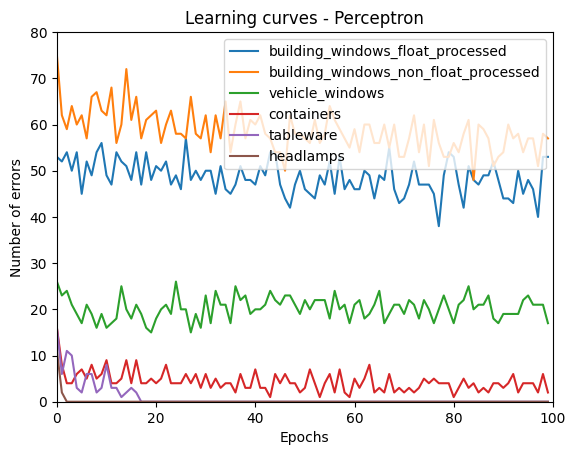

In [32]:
fig, ax = plt.subplots()

for p in ppn.perceptrons:
    ax.plot(p.errors_, label=classes[p.target_class])

ax.set_ylabel("Number of errors")
ax.set_xlabel("Epochs")
ax.legend(loc="upper right")
ax.set_title("Learning curves - Perceptron")
ax.set_xlim(0, ppn.n_iter)
ax.set_ylim(0, None)

In [33]:
y_pred = ppn.predict(X_test)

y_pred

array([1, 2, 7, 1, 2, 2, 5, 1, 3, 7, 5, 2, 7, 3, 1, 1, 5, 2, 2, 7, 7, 3,
       6, 1, 1, 6, 5, 1, 1, 2, 7, 1, 2, 7, 1, 7, 5, 1, 7, 7, 5, 1, 1, 2,
       1, 2, 2, 7, 6, 5, 1, 1, 5, 2, 7, 2, 3, 1, 1, 3, 2, 2, 7, 2, 2, 7,
       3, 5, 3, 7, 1, 2, 6, 1])

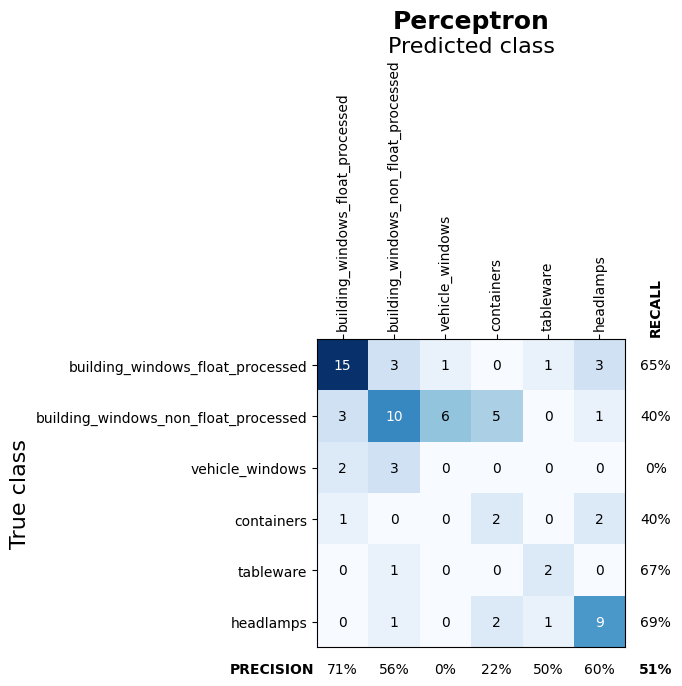

In [34]:
confusion_matrix = compute_confusion_matrix(y_test, y_pred, classes.values())

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
display_confusion_matrix(ax, confusion_matrix, title="Perceptron")